In [101]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns #!pip install seaborn
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import requests
import pprint
from config import map_key

In [102]:
url='http://www.mapquestapi.com/geocoding/v1/address?key=' + map_key + '&location='
url

'http://www.mapquestapi.com/geocoding/v1/address?key=AVGKdlu1IdakAmuexFuRz46D89fhRGZj&location='

In [103]:
# Create a reference to the CSV and import it into a Pandas DataFrame
nyc_airbnb_data = "nyc_airbnd_data.csv"
nyc_airbnb_df = pd.read_csv(nyc_airbnb_data)
nyc_airbnb_df.head().style

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.6475,-73.9724,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.7536,-73.9838,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.9419,Private room,150,3,0,nan,nan,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.6851,-73.9598,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.7985,-73.944,Entire home/apt,80,10,9,2018-11-19,0.1,1,0


In [104]:
# Create DataFrama
nyc_airbnb = nyc_airbnb_df[["name", "neighbourhood_group", "neighbourhood", "room_type", "price", 
                            "minimum_nights", "availability_365", "id"]]
nyc_airbnb.head()

,name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,availability_365,id
0,Clean & quiet apt home by the park,Brooklyn,Kensington,Private room,149,1,365,2539
1,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,355,2595
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,Private room,150,3,365,3647
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,194,3831
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,Entire home/apt,80,10,0,5022


In [105]:
# Rename columns
nyc_airbnb = nyc_airbnb.rename(columns={"name": "Name",
                                        "neighbourhood_group": "Borough",
                                        "neighbourhood": "Neighborhood",
                                        "room_type": "Room Type",
                                        "price": "Price",
                                        "minimum_nights": "Minimum Nights",
                                        "availability_365": "Yearly Availability",
                                        "id": "ID"})

nyc_airbnb.head().style

,Name,Borough,Neighborhood,Room Type,Price,Minimum Nights,Yearly Availability,ID
0,Clean & quiet apt home by the park,Brooklyn,Kensington,Private room,149,1,365,2539
1,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,355,2595
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,Private room,150,3,365,3647
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,194,3831
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,Entire home/apt,80,10,0,5022


In [106]:
#DROP ROWS WHERE YEARLY AVAILABILITY = 0
airbnb_df = nyc_airbnb[nyc_airbnb["Yearly Availability"] != 0]
# Reset Index
airbnb_df.reset_index(inplace=True,drop=True)
airbnb_df.head()

,Name,Borough,Neighborhood,Room Type,Price,Minimum Nights,Yearly Availability,ID
0,Clean & quiet apt home by the park,Brooklyn,Kensington,Private room,149,1,365,2539
1,Skylit Midtown Castle,Manhattan,Midtown,Entire home/apt,225,1,355,2595
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,Private room,150,3,365,3647
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,Entire home/apt,89,1,194,3831
4,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,Entire home/apt,200,3,129,5099


                            PATRICIA

In [107]:
B = airbnb_df.sort_values(
    ['Borough', 'Neighborhood'])


In [108]:
BnN = B.drop(['Name', 'Minimum Nights', 'Yearly Availability'], axis=1).reset_index(drop=True)
BnN.head()

,Borough,Neighborhood,Room Type,Price,ID
0,Bronx,Allerton,Entire home/apt,125,182177
1,Bronx,Allerton,Private room,35,498120
2,Bronx,Allerton,Private room,39,715270
3,Bronx,Allerton,Entire home/apt,49,755528
4,Bronx,Allerton,Private room,38,773041


In [109]:
terms=[]
for _,row in BnN.iterrows():
   term=row['Neighborhood']+','+row['Borough']+', NYC'
   if term not in terms:
       terms.append(term)
len(terms)
lats=[]
lngs=[]
locs=[]
for term in terms:
   try:
       queryurl=url+term
       response=requests.get(queryurl).json()
       pair=response['results'][0]['locations'][0]['latLng']
       lats.append(pair['lat'])
       lngs.append(pair['lng'])
       locs.append(term)
   except:
       continue
Ns=[]
Bs=[]
for loc in locs:
   s=loc.split(',')
   Ns.append(s[0])
   Bs.append(s[1])
newdf=pd.DataFrame({'lats':lats,'lngs':lngs,'Neighborhood':Ns,'Borough':Bs})
BnN=BnN.merge(newdf,how='left',on=['Neighborhood','Borough'])


In [110]:
response['results'][0]['locations'][0]['latLng']
price = BnN["Price"].astype(float)

In [111]:
lats = BnN['lats']

lngs = BnN['lngs']
prices=BnN['Price']

In [112]:
from ipyleaflet import Map, Heatmap, Marker, MarkerCluster

m = Map(center=(40.730610, -73.935242), zoom=10, dragging=True)

In [113]:
marker_locs=[]
for i in range(0,len(prices)):
    marker_loc =  lats[i],lngs[i],prices[i]
    marker_locs.append(marker_loc)

In [114]:
heatmap = Heatmap(
    locations=marker_locs,

    
)

 #Change some attributes of the heatmap
heatmap.radius = 10
heatmap.blur = 5
heatmap.max = 1000
heatmap.gradient = {0.4: 'lime', 0.6: 'cyan', 0.7: 'yellow', 0.8: 'orange', 1.0: 'red'}

m.add_layer(heatmap);

print(marker_locs[0])
m

(40.86553, -73.86247, 125)


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [115]:
# Create the bins in which Data will be held
# Bins are 0, 59, 69, 79, 89, 100.   
bins = [0, 49, 99, 149, 199, 249, 299, 10000]

# Create the names for the four bins
group_names = ["< 50", "50-99", "100-149", "150-199", "200-249", "250-299","> 300"]

BnN["Price Summary per Neighborhood"] = pd.cut(BnN["Price"], bins, labels=group_names)
BnN.head()

,Borough,Neighborhood,Room Type,Price,ID,lats,lngs,Price Summary per Neighborhood
0,Bronx,Allerton,Entire home/apt,125,182177,40.86553,-73.86247,100-149
1,Bronx,Allerton,Private room,35,498120,40.86553,-73.86247,< 50
2,Bronx,Allerton,Private room,39,715270,40.86553,-73.86247,< 50
3,Bronx,Allerton,Entire home/apt,49,755528,40.86553,-73.86247,< 50
4,Bronx,Allerton,Private room,38,773041,40.86553,-73.86247,< 50


In [116]:
#number of apartments available per price group
# Split up our data into groups based upon 'price'
# Find out how many apts are available is each price range
BnN_Price = BnN.groupby("Price Summary per Neighborhood").count()
apt_price = BnN_Price.drop(['Borough','Neighborhood','Room Type','lats','lngs'], axis=1)
apt_price.head()

,Price,ID
Price Summary per Neighborhood,,
< 50,3103,3103
50-99,10426,10426
100-149,6207,6207
150-199,4645,4645
200-249,2408,2408


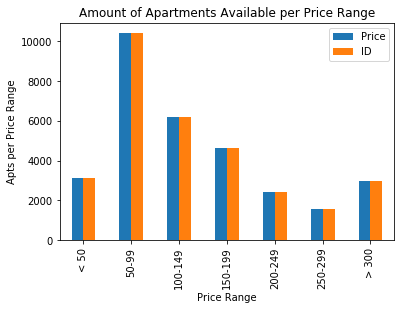

<Figure size 432x288 with 0 Axes>

In [117]:
import matplotlib.pyplot as plt

# Chart our data, give it a title, and label the axes
Apt_price = apt_price.plot(kind="bar", title="Amount of Apartments Available per Price Range")
Apt_price.set_xlabel("Price Range")
Apt_price.set_ylabel("Apts per Price Range")

plt.show()
plt.tight_layout()

                        MANUELA

In [118]:
first_df = airbnb_df[["Yearly Availability", "Room Type"]]
first_df.head()

,Yearly Availability,Room Type
0,365,Private room
1,355,Entire home/apt
2,365,Private room
3,194,Entire home/apt
4,129,Entire home/apt


In [119]:
roomtgrouped = first_df.groupby(["Room Type"]).count()
roomtgroupeddf = pd.DataFrame(roomtgrouped)
roomtgroupeddf.reset_index(level = None, inplace = True)
roomtgroupeddf = roomtgroupeddf.rename(columns = {"Yearly Availability" : "Sum of Days Available During the Year"})
roomtgroupeddf

,Room Type,Sum of Days Available During the Year
0,Entire home/apt,16533
1,Private room,13965
2,Shared room,864


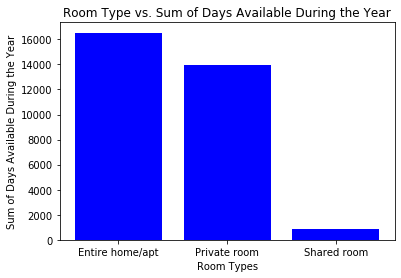

<Figure size 432x288 with 0 Axes>

In [120]:
y_axis = roomtgroupeddf["Sum of Days Available During the Year"]
x_axis = roomtgroupeddf["Room Type"]
plt.bar(x_axis, y_axis, color="b", align="center")
plt.title("Room Type vs. Sum of Days Available During the Year")
plt.xlabel("Room Types")
plt.ylabel("Sum of Days Available During the Year")


plt.show()
plt.tight_layout()

In [121]:
# IN THE NEW YORK AREA, THERE'S HIGHER AVAILABILITY OF ENTIRE APARTMENTS THROUGHOUT THE YEAR (GREATER AMOUNT OF DAYS AVAILABLE). SECOND IS PRIVATE ROOMS, AND THIRD IS A SMALL AMOUNT OF SHARED ROOMS AVAILABLE.

In [122]:
second_df = airbnb_df[["Borough", "Room Type"]]
second_df.head()

,Borough,Room Type
0,Brooklyn,Private room
1,Manhattan,Entire home/apt
2,Manhattan,Private room
3,Brooklyn,Entire home/apt
4,Manhattan,Entire home/apt


In [123]:
boroughgrouped = second_df.groupby(["Borough"]).count()
boroughgroupeddf = pd.DataFrame(boroughgrouped)
boroughgroupeddf.reset_index(level = None, inplace = True)
boroughgroupeddf = boroughgroupeddf.rename(columns = {"Room Type" : "Total Number of Rooms/ Apts"})
boroughgroupeddf

,Borough,Total Number of Rooms/ Apts
0,Bronx,914
1,Brooklyn,12260
2,Manhattan,13559
3,Queens,4298
4,Staten Island,331


In [124]:
y2_axis = boroughgroupeddf["Borough"]
x2_axis = boroughgroupeddf["Total Number of Rooms/ Apts"]
colors = ["red", "orange", "lightcoral", "lightskyblue", "blue"]

([<matplotlib.patches.Wedge at 0x11fdbbdd0>,
 [Text(-0.9037660939152232, 0.6270620762645593, 'Bronx'),
  Text(-0.8319780034936637, -0.7195919688981371, 'Brooklyn'),
  Text(1.086326435919438, 0.17290134361123816, 'Manhattan'),
  Text(-0.40373054229104743, 1.023230985272327, 'Queens'),
  Text(-0.8187458979751604, 0.734612247753091, 'Staten Island')],
 [Text(-0.4929633239537581, 0.3420338597806687, '2.91435%'),
  Text(-0.4538061837238165, -0.39250471030807477, '39.09189%'),
  Text(0.5925416923196933, 0.09430982378794807, '43.23385%'),
  Text(-0.2202166594314804, 0.5581259919667237, '13.70448%'),
  Text(-0.44658867162281474, 0.4006975896835041, '1.05542%')])

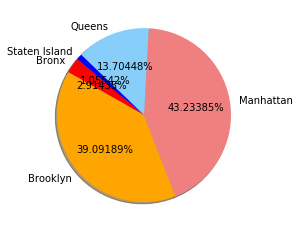

In [125]:
plt.pie(x2_axis, labels=y2_axis, colors=colors,
        autopct='%1.5f%%', shadow=True, startangle=140)


In [126]:
# THE HIGHEST NUMBER OF AVAILABLE ROOMS/ APTS ARE LOCATED IN MANHATTAN, EVEN THOUGH IS THE SMALLEST BOROUGH. NEXT IS BROOKLYN, FOLLOWED BY QUEENS.

                            SURA

In [127]:
# Groupby room type by Price average
mean_price_of_rooms = nyc_airbnb.groupby(["Room Type"],as_index=False)

# Create DataFrame
avrg_price = pd.DataFrame(mean_price_of_rooms["Price"].mean())

# Formating currency
avrg_price["Price"] = avrg_price["Price"].astype(float).map("${:,.2f}".format)
#pivot = avrg_price.pivot()

avrg_price.style

,Room Type,Price
0,Entire home/apt,$211.79
1,Private room,$89.78
2,Shared room,$70.13


In [128]:
# Create Data Frame: Total Rooms and Percentage showing which rooms we have more
room_categ = pd.DataFrame({"Total Rooms" : nyc_airbnb["Room Type"].value_counts(),
                           "Per of Room Type" : nyc_airbnb["Room Type"].value_counts()/nyc_airbnb["Room Type"].count()/1})


# Set Index and Index name
index = ["Entire home/apt", "Private room", "Shared room"]
room_categ.index.name = "Room Type"

# Format with percentage and currency style
room_categ["Per of Room Type"] = room_categ["Per of Room Type"].astype(float).map("{:.2%}".format)
room_categ.style

,Total Rooms,Per of Room Type
Room Type,,
Entire home/apt,25409,51.97%
Private room,22326,45.66%
Shared room,1160,2.37%


In [129]:
# Group by Cities
group_city = nyc_airbnb.groupby(["Borough"],as_index=False)

# Create Data Frame by Price
city_avrg_prices = pd.DataFrame(group_city["Price"].mean())

# Create formating currency for Price column
city_avrg_prices["Price"] = city_avrg_prices["Price"].astype(float).map("${:,.2f}".format)

# Show Data Frame by style (bold index)
city_avrg_prices.style

,Borough,Price
0,Bronx,$87.50
1,Brooklyn,$124.38
2,Manhattan,$196.88
3,Queens,$99.52
4,Staten Island,$114.81


In [130]:
# Print both datas inside the window for preview
pd.set_option("display.max_rows", None)
print ("Room Category:")
print ("-----------------")
display(room_categ)
print ("Avarage Price:")
print ("-----------------")
display(avrg_price)
print ("Borough:")
print ("-----------------")
display(city_avrg_prices)

Room Category:
-----------------


,Total Rooms,Per of Room Type
Room Type,,
Entire home/apt,25409,51.97%
Private room,22326,45.66%
Shared room,1160,2.37%


Avarage Price:
-----------------


,Room Type,Price
0,Entire home/apt,$211.79
1,Private room,$89.78
2,Shared room,$70.13


Borough:
-----------------


,Borough,Price
0,Bronx,$87.50
1,Brooklyn,$124.38
2,Manhattan,$196.88
3,Queens,$99.52
4,Staten Island,$114.81


In [131]:
# Merge both DataFrames
merge_room_type = pd.merge(avrg_price, room_categ, on="Room Type")
pd.DataFrame(merge_room_type)
merge_room_type.style

,Room Type,Price,Total Rooms,Per of Room Type
0,Entire home/apt,$211.79,25409,51.97%
1,Private room,$89.78,22326,45.66%
2,Shared room,$70.13,1160,2.37%


In [132]:
# Adding Cities column to Data Frame
city_list = nyc_airbnb["Borough"]
merge_room_type["Borough"] = city_list
  
# Lock table
locked_table = merge_room_type.loc[:, ["Room Type", "Price", "Total Rooms", "Per of Room Type", "Borough"]]
locked_table

,Room Type,Price,Total Rooms,Per of Room Type,Borough
0,Entire home/apt,$211.79,25409,51.97%,Brooklyn
1,Private room,$89.78,22326,45.66%,Manhattan
2,Shared room,$70.13,1160,2.37%,Manhattan


In [133]:
# Remove $ from Price column - for be able to create the error bar
locked_table["Price"] = locked_table["Price"].apply(lambda x:float(x.strip('$')))

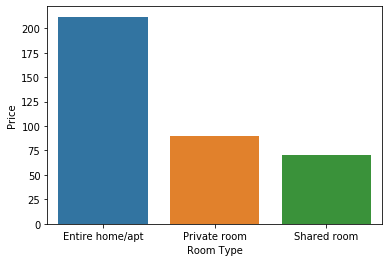

In [134]:
# Grouping by Cities and Room Type
# Setting index by false to see nice Data Frame
airbnb_new = locked_table.groupby(["Borough", "Room Type"],as_index=False)["Price"].mean()

# Show Data Frame by index style
airbnb_new.style

# Show Bar by seaborn (it's will shows you matplotlib errors bar by different color)
sns.barplot(airbnb_new["Room Type"], airbnb_new["Price"])

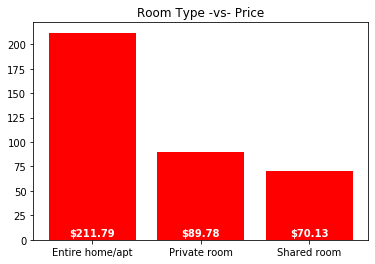

In [135]:
# Defind y values by price
y = airbnb_new["Price"].values

# Create plt bar
airbnb_bar = plt.bar(airbnb_new["Room Type"],airbnb_new["Price"], color = "r")

#Creating title 
plt.title("Room Type -vs- Price")

# Set up price by Roofor each bar
def autolabel(rects):
    for i,rect in enumerate(rects):
        plt.text(rect.get_x() + rect.get_width()/2., 2, '$%s'% (y[i]), ha="center", va="bottom", 
                 color="white", weight="bold")
                  

autolabel(airbnb_bar)

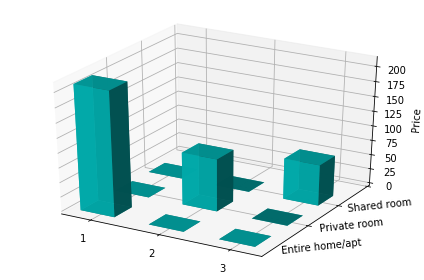

In [136]:
# Set price and room type for new DataFrame
prices = airbnb_new["Price"].values
type_of_r = airbnb_new["Room Type"]

# Create new Data Frame
data = pd.DataFrame({"in": [1,2,3], "r": type_of_r, "p": prices})

# Set 3D projection 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Show projection
ax

# Create pivot table
piv_tbl = pd.pivot_table(data, values="p", index="in", columns="r")

# Set all x, y  for 3D graph
xpos = np.arange(piv_tbl.shape[0])
ypos = np.arange(piv_tbl.shape[1])
xpos, ypos = np.meshgrid(xpos+0.25, ypos+0.25)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(piv_tbl.shape).flatten()

# Set delta x, y, z
dx = 0.5 * np.ones_like(zpos)
dy = 0.5 * np.ones_like(zpos)
dz = piv_tbl.values.ravel()
# Setting 
dz[np.isnan(dz)] = 0.

# Set 3D graph - adding color and shape 
    # with alpha showing dept(thickness)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color="c", alpha=0.9)


ax.set_xticks([.5, 1.5, 2.5])
ax.set_yticks([1.5, 2.5, 3.5])

# Set index and columns of graph
ax.w_xaxis.set_ticklabels(piv_tbl.index)
ax.w_yaxis.set_ticklabels(piv_tbl.columns, rotation=6)

# Set grid colors and linestyle
    #ax.zaxis._axinfo["grid"]['color'] = "c"
    #ax.zaxis._axinfo["grid"]['linestyle'] = "-"

# Formating for label and tight
fig.tight_layout()
ax.set_zlabel("Price")

# Show 3D histogram
plt.show()

                Gilbert

        Yearly Availability By Borough

In [193]:
newdf = airbnb_df.groupby(['Neighborhood','Borough'],as_index=False)['Yearly Availability'].mean()
newdf.head(10)

,Neighborhood,Borough,Yearly Availability
0,Allerton,Bronx,185.783784
1,Arden Heights,Staten Island,125.666667
2,Arrochar,Staten Island,255.809524
3,Arverne,Queens,198.753425
4,Astoria,Queens,179.328467
5,Bath Beach,Brooklyn,222.266667
6,Battery Park City,Manhattan,206.558824
7,Bay Ridge,Brooklyn,190.122642
8,Bay Terrace,Queens,222.500000
9,Baychester,Bronx,184.166667


In [204]:
newnew = newdf.drop([0, 1, 2, 3,4,5,6,11,12,13,16,17,18,20,23,24,25,26, 
                     34,32,33,36,37,38,39,43,44,42,45,46,48,56,57,58,59,
                     53,52, 188,21,31,41,51,61,65,67,66,68,69,70,71,72,73,
                     74,75,76,77, 196,78,79,89,88,87,86,85,84,81,92,93,94,95,
                     96,97,98,101,100,111,123,124,112,114,143,154,165,129,130,
                     140,150,160,161,171,14,22,162,165,167,166,186,176,156,
                     189,200,212,213,214,215,216,203,204,205,206,207,209,191,
                     192,193,194,195,197,156,157,158,159,10,19,28,29,7,50,55,
                     60,62,82,90,99,64,102,103,107,113,115,141,142,144,135,
                     155,164,168,170,172,177,185,187,190,183,202,47,49,54,80,
                     109, 104,105,106,107,119,120,121,122,151,152,153,161,199,
                     145,146,147,148,174,175,176,169,181,198,91,117,110,83,35])

newnew = newnew.reset_index(drop=True)
newnew.head()

,Neighborhood,Borough,Yearly Availability
0,Bay Terrace,Queens,222.500000
1,Baychester,Bronx,184.166667
2,Belmont,Bronx,264.941176
3,Bushwick,Brooklyn,162.548654
4,Carroll Gardens,Brooklyn,136.877049


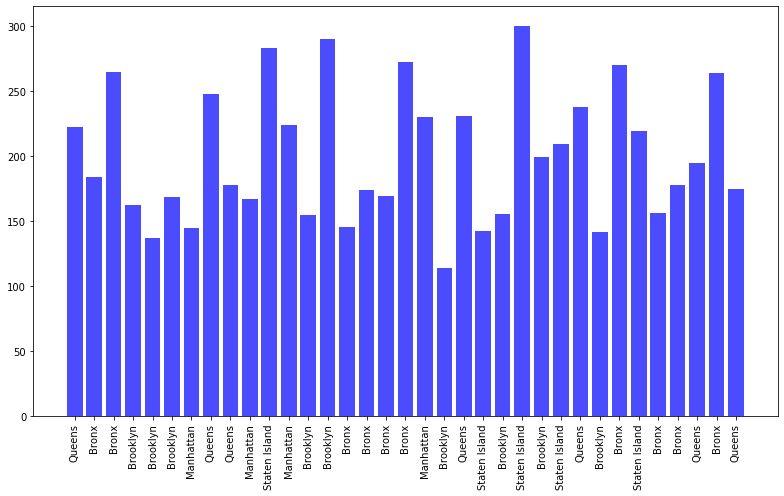

In [233]:
# Set x axis and tick locations
x_axis = np.arange(len(newnew))
tick_locations = [value+0.8 for value in x_axis]
y = newnew["Yearly Availability"]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(11,7))
plt.bar(x_axis, y, color='b', alpha=0.7, align="center")
plt.xticks(newnew.index, newnew["Borough"], rotation="vertical")
plt.tight_layout()
plt.show()

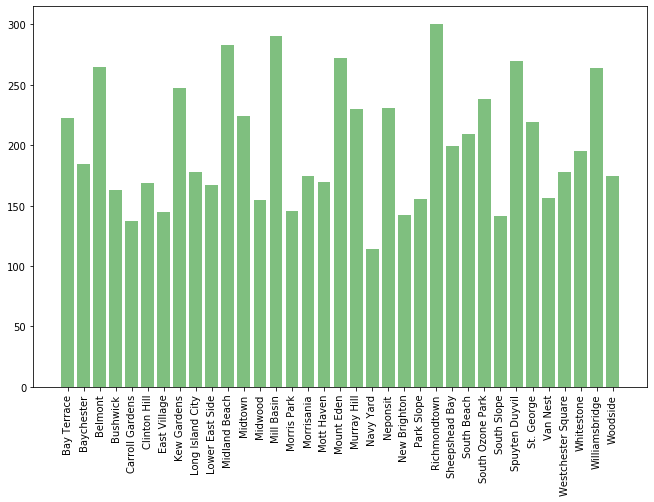

In [237]:
plt.figure(figsize=(11,7))
plt.bar(x_axis, y, color='g', alpha=0.5, align="center")
plt.xticks(newnew.index, newnew["Neighborhood"], rotation="vertical")
plt.show()